# Credit Scorecard for Risk-Based Loan Default Prediction (with WOE & IV Feature Selection)

Objective:
Build a transparent, interpretable, and scalable credit risk model using logistic regression - enhanced with industry-standard WOE binning and IV-based feature selection - to predict the probability of loan default.

In [1]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

# Silence warnings to keep output clean
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

# Data Preparation

## Explore Data

In [2]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    return df

In [3]:
df = wrangle("../data/loan/loan.csv")

In [4]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,8.873790e+05,8.873790e+05,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,8.873750e+05,887379.000000,887350.000000,...,21372.000000,18617.000000,21372.000000,21372.000000,21372.000000,21372.000000,8.171030e+05,21372.000000,21372.000000,21372.000000
mean,3.246513e+07,3.500182e+07,14755.264605,14741.877625,14702.464383,13.246740,436.717127,7.502759e+04,18.157039,0.314442,...,36552.811389,71.535317,1.389060,2.975482,5887.979740,60.831939,3.206862e+04,0.943945,1.537058,1.977307
std,2.282734e+07,2.411335e+07,8435.455601,8429.897657,8442.106732,4.381867,244.186593,6.469830e+04,17.190626,0.862244,...,43103.833619,23.022862,1.520129,2.631886,5284.701239,20.013254,3.749826e+04,1.446872,2.723339,2.874067
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.320000,15.670000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-4.000000
25%,9.206643e+06,1.087713e+07,8000.000000,8000.000000,8000.000000,9.990000,260.705000,4.500000e+04,11.910000,0.000000,...,10251.500000,58.600000,0.000000,1.000000,2411.000000,47.700000,1.390000e+04,0.000000,0.000000,0.000000
50%,3.443327e+07,3.709528e+07,13000.000000,13000.000000,13000.000000,12.990000,382.550000,6.500000e+04,17.650000,0.000000,...,24684.500000,74.900000,1.000000,2.000000,4483.000000,61.900000,2.370000e+04,0.000000,0.000000,2.000000
75%,5.490814e+07,5.847135e+07,20000.000000,20000.000000,20000.000000,16.200000,572.600000,9.000000e+04,23.950000,0.000000,...,47858.000000,87.600000,2.000000,4.000000,7771.500000,75.200000,3.980000e+04,1.000000,2.000000,3.000000
max,6.861706e+07,7.354484e+07,35000.000000,35000.000000,35000.000000,28.990000,1445.460000,9.500000e+06,9999.000000,39.000000,...,878459.000000,223.300000,22.000000,43.000000,127305.000000,151.400000,9.999999e+06,17.000000,35.000000,32.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

In [7]:
df.isnull().sum()

id                       0
member_id                0
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
                     ...  
all_util            866007
total_rev_hi_lim     70276
inq_fi              866007
total_cu_tl         866007
inq_last_12m        866007
Length: 74, dtype: int64

In [8]:
print("Duplicate Rows:", df.duplicated().sum())

Duplicate Rows: 0


In [9]:
df.nunique()

id                  887379
member_id           887379
loan_amnt             1372
funded_amnt           1372
funded_amnt_inv       9856
                     ...  
all_util              1128
total_rev_hi_lim     21251
inq_fi                  18
total_cu_tl             33
inq_last_12m            29
Length: 74, dtype: int64

### Dataset Exploration Summary

After loading and exploring the dataset, several key observations about the data quality and structure were made:

#### 1. Data Volume
- **~887,000 rows** and **74 columns** → a very large and rich dataset.
- ✅ Sufficient sample size to build a robust credit scorecard.

#### 2. Feature Types
- **Continuous variables** (e.g., `loan_amnt`, `int_rate`, `annual_inc`, `dti`).
- **Categorical variables** (e.g., `term`, `grade`, `purpose`, `home_ownership`).
- **Text fields** (e.g., `emp_title`, `desc`) that would require heavy cleaning → likely not used.
- **Timestamp fields** (e.g., `issue_d`, `earliest_cr_line`) → candidates for feature engineering.

✅ Good variety to engineer **meaningful predictive features**.

#### 3. Data Quality: Missing Values
- **Extreme missingness** (>95%) in fields like:
  - `il_util`, `open_il_24m`, `all_util`, etc.
  - → Likely useless for modeling — will be dropped.
- **Moderate missingness** (~5–10%) in features like:
  - `total_rev_hi_lim`, `tot_coll_amt`, `tot_cur_bal`
  - → Reasonable, can be imputed safely.

✅ Overall: **Manageable missingness** once high-missing columns are removed.

#### 4. Data Quality: Duplicates
- **No duplicate rows** detected.

#### 5. Suspicious Columns (Potential Leakage)
- Some fields reflect **post-loan performance**, such as:
  - `total_pymnt`, `out_prncp`, `recoveries`, `collection_recovery_fee`
- → These are future information and must be dropped before modeling.

#### 6. ID Columns and Overgranularity
- Columns like `id`, `member_id`, and `url`:
  - Unique values per row → pure identifiers, no predictive value → will be dropped.
- Columns like `emp_title`:
  - Extremely high cardinality (hundreds of thousands of unique entries).
  - → Difficult to model directly without NLP techniques → will be ignored for now.


## Define the Modeling Target

In [10]:
# Explore unique values in loan_status
df['loan_status'].value_counts(dropna=False)

loan_status
Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: count, dtype: int64

**Observation**:
- Most borrowers are Current or Fully Paid (good outcomes).
- A smaller percentage are Charged Off, Default, or Late (bad outcomes).
- Some statuses like Issued, In Grace Period are ambiguous.

**Target Mapping**

| Original Loan Status                            | Meaning                            | Final Mapping         |
|--------------------------------------------------|------------------------------------|------------------------|
| Fully Paid, Current                             | Paid off or still performing       | ✅ Good (0)            |
| Charged Off, Default, Late (16-120 days)        | Severe delinquency or default      | ❌ Bad (1)             |
| Issued, In Grace Period                         | Ambiguous                          | 🚫 Exclude from modeling |

In [11]:
def map_loan_status(x):
    if x in ['Charged Off', 'Default', 'Late (31-120 days)', 'Late (16-30 days)', 'Does not meet the credit policy. Status:Charged Off']:
        return 1   # BAD borrower
    elif x in ['Fully Paid', 'Current', 'Does not meet the credit policy. Status:Fully Paid']:
        return 0   # GOOD borrower
    else:
        return None  # Exclude these

In [12]:
df['target'] = df['loan_status'].apply(map_loan_status)
df = df.dropna(subset=['target'])  # Remove rows without a clear target
df['target'] = df['target'].astype(int)

In [13]:
# Count and percentage distribution
class_counts = df['target'].value_counts()
class_percent = df['target'].value_counts(normalize=True) * 100

# Display as table
balance_df = pd.DataFrame({
    'Count': class_counts,
    'Percentage': class_percent.round(2)
}).rename(index={0: 'Good (0)', 1: 'Bad (1)'})

print("📊 Class Balance:")
print(balance_df)

📊 Class Balance:
           Count  Percentage
target                      
Good (0)  811490       92.99
Bad (1)    61176        7.01


The dataset is heavily imbalanced, with only ~7% of loans classified as defaulted or risky.

This is typical in credit risk modeling, where defaults are relatively rare but high-stakes.

Accuracy is not a reliable metric here. Instead, we will use:
- ROC AUC (area under the curve)
- KS Statistic

We do not need to balance the data manually for scorecard modeling, since:
- Logistic regression + WOE works well even under imbalance
- We evaluate using ranking metrics, not hard labels

But we will need to perform stratified train-test split to preserve the imbalance in both sets

## Drop Meaningless and Future Leakage Columns

Data leakage refers to including variables in training that contain information not available at prediction time.
This inflates performance and leads to models that fail in production.
For example, `total_pymnt` is known only after the borrower repays (or defaults) - including it would leak the outcome.

✅ Dropping these columns ensures the model only uses features available at loan approval time, which is critical for real-world deployability.

Remove features that are:
- Non-predictive (e.g., identifiers, URLs)
- High-risk for data leakage (i.e., they contain future information unavailable at loan origination)
- Sparse, redundant, or too messy to clean effectively

**Columns Dropped & Reasons**

| Column(s)                                                  | Reason                                               |
|------------------------------------------------------------|------------------------------------------------------|
| id, member_id                                              | Pure identifiers - not predictive                    |
| loan_status                                                | Already mapped to the target variable                |
| url, zip_code                                              | Internal link / privacy-sensitive granular data      |
| desc, emp_title                                            | Free-text fields - would need NLP cleaning           |
| title                                                      | User-generated - redundant with purpose              |
| policy_code                                                | Almost always 1 - no variance                        |
| annual_inc_joint, dti_joint, verification_status_joint     | Valid only for joint apps (rare rows)                |
| next_pymnt_d, last_pymnt_d, last_credit_pull_d            | Future information → data leakage                    |
| out_prncp, total_pymnt, recoveries, etc.                  | Post-loan performance metrics → leakage              |
| mths_since_last_major_derog                               | >70% missing - dropped due to poor quality           |


In [14]:
drop_cols = [
    'id', 'member_id', 'loan_status', 'url', 'desc', 'title', 'zip_code',
    'policy_code', 'next_pymnt_d', 'last_pymnt_d', 'last_credit_pull_d',
    'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'emp_title',
    'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
    'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
    'recoveries', 'collection_recovery_fee', 'mths_since_last_major_derog'
]

In [15]:
df = df.drop(columns=drop_cols)

## Handle High-Cardinality Categorical & Timestamp Columns

Fix columns with too many unique values (i.e., high-cardinality) that are likely:
- IDs in disguise (not useful for modeling), or
- Timestamps or free-text fields that should be engineered or removed

In [16]:
# Group Categorical Columns by Uniqueness
def group_columns_by_uniques(df):
    unique_counts = df.nunique().sort_values()
cat_cols = df.select_dtypes(include='object').columns
cat_uniques = df[cat_cols].nunique().sort_values()


for n_unique in sorted(cat_uniques.unique()):
    cols_in_group = cat_uniques[cat_uniques == n_unique].index.tolist()
    print(f"\nColumns with {n_unique} unique values:")
    for col in cols_in_group:
        print(f"  - {col}")


Columns with 2 unique values:
  - term
  - pymnt_plan
  - initial_list_status
  - application_type

Columns with 3 unique values:
  - verification_status

Columns with 6 unique values:
  - home_ownership

Columns with 7 unique values:
  - grade

Columns with 11 unique values:
  - emp_length

Columns with 14 unique values:
  - purpose

Columns with 35 unique values:
  - sub_grade

Columns with 51 unique values:
  - addr_state

Columns with 103 unique values:
  - issue_d

Columns with 697 unique values:
  - earliest_cr_line


We can get from this:
- Binary categories (safe to keep)
- Medium-cardinality categories (e.g., purpose, emp_length) → can one-hot or encode
- Very high-cardinality columns like issue_d, earliest_cr_line → typically timestamps

In [17]:
# Examine & Convert Date Features
print("Sample values of issue_d:")
print(df['issue_d'].dropna().unique()[:10])

print("\nSample values of earliest_cr_line:")
print(df['earliest_cr_line'].dropna().unique()[:10])

Sample values of issue_d:
['Dec-2011' 'Nov-2011' 'Oct-2011' 'Sep-2011' 'Aug-2011' 'Jul-2011'
 'Jun-2011' 'May-2011' 'Apr-2011' 'Mar-2011']

Sample values of earliest_cr_line:
['Jan-1985' 'Apr-1999' 'Nov-2001' 'Feb-1996' 'Jan-1996' 'Nov-2004'
 'Jul-2005' 'Jan-2007' 'Apr-2004' 'Sep-2004']


Both `issue_d` and `earliest_cr_line` are in `%b-%Y` format (e.g., "Jan-2011").

They are timestamps - not raw categories. We don't drop them immediately.

**Feature Engineering - Credit History Length**

The length of a borrower’s credit history is a strong risk indicator:
- Longer history → more credit exposure → potentially more stable borrower
- Shorter history → limited behavior → higher uncertainty

In [18]:
# Convert to datetime
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y', errors='coerce')

# Create credit history length (in years)
df['credit_history_length'] = (df['issue_d'] - df['earliest_cr_line']).dt.days / 365

# Drop all date columns
df = df.drop(columns=['issue_d', 'earliest_cr_line'])

## Handle Missing Values

Missing values are extremely common in credit data — especially for behavioral indicators like delinquencies or inquiries.
Rather than remove rows, we treat missingness strategically to avoid information loss while ensuring modeling stability.

In [19]:
# Quantify Missingness
missing_report = df.isnull().mean() * 100
missing_report = missing_report[missing_report > 0].sort_values(ascending=False)
print(missing_report)

il_util                       98.669709
mths_since_rcnt_il            98.517875
total_bal_il                  98.477310
open_il_24m                   98.477310
open_il_12m                   98.477310
open_acc_6m                   98.477310
open_rv_12m                   98.477310
open_rv_24m                   98.477310
open_il_6m                    98.477310
all_util                      98.477310
inq_fi                        98.477310
total_cu_tl                   98.477310
inq_last_12m                  98.477310
max_bal_bc                    98.477310
mths_since_last_record        84.593533
mths_since_last_delinq        51.285944
total_rev_hi_lim               8.045461
tot_coll_amt                   8.045461
tot_cur_bal                    8.045461
emp_length                     5.036979
revol_util                     0.056952
collections_12_mths_ex_med     0.016616
acc_now_delinq                 0.003323
total_acc                      0.003323
pub_rec                        0.003323


**Strategy Table**

| Missing %   | Strategy      | Reason                                                     |
|-------------|---------------|------------------------------------------------------------|
| >95%        | Drop          | Almost entirely missing → not reliable                    |
| ~50–85%     | Case-by-case  | Retained only if IV is strong or business critical         |
| <10%        | Impute        | Safe to fill using median (numeric) or mode (categorical)  |

In [20]:
# Drop Heavily Missing Features
drop_heavy_missing = [
    'il_util', 'mths_since_rcnt_il', 'total_bal_il', 'open_il_24m',
    'open_il_12m', 'open_acc_6m', 'open_rv_12m', 'open_rv_24m',
    'open_il_6m', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'max_bal_bc'
]

In [21]:
df = df.drop(columns=drop_heavy_missing)

In [22]:
# Impute Remaining Missing Features
impute_ok = [
    'total_rev_hi_lim', 'tot_coll_amt', 'tot_cur_bal', 'emp_length',
    'revol_util', 'collections_12_mths_ex_med', 'acc_now_delinq',
    'total_acc', 'pub_rec', 'open_acc', 'inq_last_6mths',
    'delinq_2yrs', 'credit_history_length', 'annual_inc',
    'mths_since_last_record', 'mths_since_last_delinq'  
]

| Type of Column              | How to Impute          | Why                                                                                     |
|----------------------------|------------------------|------------------------------------------------------------------------------------------|
| Numerical columns (floats, ints) | Median                 | Median is robust to outliers and skewed distributions (which is common in finance data). |
| Categorical columns (objects)    | Mode (most frequent value) | Because it preserves the dominant category without introducing new values.             |


In [23]:
# Numerical columns in impute_ok (excluding 'emp_length' which is object)
numerical_to_impute = [col for col in impute_ok if col != 'emp_length']

for col in numerical_to_impute:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)
    print(f"Filled missing values in numerical column: {col} with median: {median_val}")

# emp_length is categorical → use mode
mode_val = df['emp_length'].mode()[0]
df['emp_length'] = df['emp_length'].fillna(mode_val)
print(f"Filled missing values in categorical column: emp_length with mode: {mode_val}")

Filled missing values in numerical column: total_rev_hi_lim with median: 23700.0
Filled missing values in numerical column: tot_coll_amt with median: 0.0
Filled missing values in numerical column: tot_cur_bal with median: 80603.0
Filled missing values in numerical column: revol_util with median: 56.0
Filled missing values in numerical column: collections_12_mths_ex_med with median: 0.0
Filled missing values in numerical column: acc_now_delinq with median: 0.0
Filled missing values in numerical column: total_acc with median: 24.0
Filled missing values in numerical column: pub_rec with median: 0.0
Filled missing values in numerical column: open_acc with median: 11.0
Filled missing values in numerical column: inq_last_6mths with median: 0.0
Filled missing values in numerical column: delinq_2yrs with median: 0.0
Filled missing values in numerical column: credit_history_length with median: 14.846575342465753
Filled missing values in numerical column: annual_inc with median: 64800.0
Filled m

# Feature Engineering

## Loan Burden Ratio

While `dti` (debt-to-income) and `loan_amnt` are often used in risk modeling, they each tell only part of the story. `loan_burden` combines them into a single, more interpretable measure of how much of a borrower's income will be strained by the new loan.

**Formula:**
$$
loanburden = loan amnt / (annual inc + 1)
$$
The `+1` prevents division-by-zero errors.

**Why It Works:**

- It contextualizes loan size relative to the applicant's income.
- High values → borrower is taking a large loan relative to earnings - a key signal of overextension or potential risk.
- Helps simplify modeling by consolidating two correlated variables (`loan_amnt` and `annual_inc`) into a single, interpretable feature.

In [24]:
df['loan_burden'] = df['loan_amnt'] / (df['annual_inc'] + 1)

In [25]:
df = df.drop(columns=['loan_amnt', 'dti'])

# Feature Binning

Binning converts continuous features into discrete intervals that:
- Capture non-linear relationships with the target (e.g., credit risk),
- Enforce monotonic trends (essential for stable scorecards),
- Allow us to apply WOE (Weight of Evidence) transformation easily.
- Simplifies interpretation

**Binning Methods Compared**

| Method                 | Pros                            | Cons                               | Use Case                                      |
|------------------------|----------------------------------|------------------------------------|-----------------------------------------------|
| Quantile Binning       | Fast, stable                    | Ignores target (unsupervised)      | EDA, simple models                            |
| Manual Binning         | Business-driven, interpretable  | Needs domain knowledge             | Age, income, known thresholds                 |
| Decision Tree Binning ✅ | Supervised, finds optimal splits | Slightly complex, harder to explain | Most predictive, industry standard            |

For this project, we chose decision tree binning, which finds optimal cutoffs using entropy gain, guided by the target variable.

We use a shallow Decision Tree Classifier (like a 1D CART tree) to learn the best split points. The resulting intervals (bins) group data into distinct, target-informed bands.

**🧮 Formula Behind Binning Logic (Entropy Split)**

Each potential split minimizes information entropy, where entropy is defined as:

$$
H(S) = -p_{good} \log_2(p_{good}) - p_{bad} \log_2(p_{bad})
$$

The decision tree algorithm chooses split thresholds that most reduce the entropy -  
i.e., that separate **risky** and **safe** borrowers the best.


In [26]:
def decision_tree_binning(X, y, max_leaf_nodes=5):
    X_reshaped = X.values.reshape(-1, 1)
    tree = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=max_leaf_nodes, min_samples_leaf=0.05)
    tree.fit(X_reshaped, y)

    thresholds = tree.tree_.threshold
    thresholds = thresholds[thresholds != -2]  # -2 = leaf node

    bins = [-np.inf] + sorted(thresholds.tolist()) + [np.inf]
    return bins


`max_leaf_nodes`=5 means we get at most 5 bins → this is a standard industry choice (balance between stability and granularity).

In [27]:
# List of numerical features to bin
features_to_bin = [
    'annual_inc', 'int_rate',
    'credit_history_length', 'total_rev_hi_lim',
    'open_acc', 'revol_util', 'tot_cur_bal', 'mths_since_last_record', 'mths_since_last_delinq',
    'loan_burden'
]

In [28]:
# Tree-bin each feature
for feature in features_to_bin:
    try:
        bins = decision_tree_binning(df[feature], df['target'])
        df[feature + '_bin'] = pd.cut(df[feature], bins=bins)
        print(f"Binned {feature} into {len(bins)-1} tree-based bins.")
    except Exception as e:
        print(f"❌ Could not bin {feature}: {e}")

Binned annual_inc into 5 tree-based bins.
Binned int_rate into 5 tree-based bins.
Binned credit_history_length into 5 tree-based bins.
Binned total_rev_hi_lim into 5 tree-based bins.
Binned open_acc into 5 tree-based bins.
Binned revol_util into 5 tree-based bins.
Binned tot_cur_bal into 5 tree-based bins.
Binned mths_since_last_record into 3 tree-based bins.
Binned mths_since_last_delinq into 5 tree-based bins.
Binned loan_burden into 5 tree-based bins.


# WOE (Weight of Evidence) Transformation and IV Filtering

**🧮 What is WOE?**

**Weight of Evidence (WOE)** quantifies the strength and direction of the relationship between a feature bin and the target (good/bad):

$$
WOE_i = \ln \left( \frac{\text{Distribution of Goods in Bin } i}{\text{Distribution of Bads in Bin } i} \right)
$$

- A **positive WOE** → more goods than bads in the bin (**low-risk**)  
- A **negative WOE** → more bads than goods in the bin (**high-risk**)  
- WOE values are additive and interpretable, making them ideal for logistic regression and scorecard modeling.


**Why use WOE?**

| Benefit                      | Description                                                       |
|-----------------------------|-------------------------------------------------------------------|
| Model Compatibility         | Makes features linear for logistic regression                    |
| Interpretability            | Easier to explain to business stakeholders                       |
| Handles Missing Values Naturally | Bins can include "missing"                                  |
| Encodes Monotonicity        | Ensures consistent score behavior (score ↑ when risk ↓)          |

**🔍 What is IV (Information Value)?**

**Information Value (IV)** helps select features by measuring how much predictive power each one provides:

$$
IV = \sum_{i=1}^{n} \left( \text{Dist}_{\text{good},i} - \text{Dist}_{\text{bad},i} \right) \cdot WOE_i
$$

Where:
- $\text{Dist}_{\text{good},i}$ = proportion of good observations in bin $i$  
- $\text{Dist}_{\text{bad},i}$ = proportion of bad observations in bin $i$  
- $WOE_i$ = Weight of Evidence for bin $i$

The higher the IV, the more predictive the feature is.

In [29]:
def calc_woe_iv(df, feature_bin_col, target_col='target'):
    grouped = df.groupby(feature_bin_col)[target_col].agg(['count', 'sum'])
    grouped.columns = ['total', 'bad']
    grouped['good'] = grouped['total'] - grouped['bad']
    
    dist_good = grouped['good'] / grouped['good'].sum()
    dist_bad = grouped['bad'] / grouped['bad'].sum()
    
    grouped['woe'] = np.log((dist_good + 1e-6) / (dist_bad + 1e-6))
    grouped['iv'] = (dist_good - dist_bad) * grouped['woe']
    
    woe_dict = grouped['woe'].to_dict()
    iv_score = grouped['iv'].sum()
    
    return woe_dict, iv_score

In [30]:
# Define categorical features for WOE encode
categorical_features = [
    'term',               # 2 values
    'home_ownership',     # 6 values
    'purpose',            # 14 values
    'emp_length',         # 11 values (already imputed)
    'verification_status' # 3 values (optional but simple)
]

In [31]:
woe_iv_summary = []

# 1. Apply WOE to binned numerical features
for feature in features_to_bin:
    bin_col = feature + '_bin'
    try:
        woe_map, iv_score = calc_woe_iv(df, bin_col, 'target')
        df[feature + '_woe'] = df[bin_col].map(woe_map)
        woe_iv_summary.append({'feature': feature, 'iv': iv_score})
        print(f"✅ WOE applied to numerical feature: {feature}, IV = {iv_score:.4f}")
    except Exception as e:
        print(f"❌ Failed WOE on numerical feature: {feature} — {e}")

# 2. Apply WOE to categorical features
for cat_feature in categorical_features:
    try:
        woe_map, iv_score = calc_woe_iv(df, cat_feature, 'target')
        df[cat_feature + '_woe'] = df[cat_feature].map(woe_map)
        woe_iv_summary.append({'feature': cat_feature, 'iv': iv_score})
        print(f"✅ WOE applied to categorical feature: {cat_feature}, IV = {iv_score:.4f}")
    except Exception as e:
        print(f"❌ Failed WOE on categorical feature: {cat_feature} — {e}")

✅ WOE applied to numerical feature: annual_inc, IV = 0.0539
✅ WOE applied to numerical feature: int_rate, IV = 0.5026
✅ WOE applied to numerical feature: credit_history_length, IV = 0.0447
✅ WOE applied to numerical feature: total_rev_hi_lim, IV = 0.1483
✅ WOE applied to numerical feature: open_acc, IV = 0.0052
✅ WOE applied to numerical feature: revol_util, IV = 0.0353
✅ WOE applied to numerical feature: tot_cur_bal, IV = 0.1340
✅ WOE applied to numerical feature: mths_since_last_record, IV = 0.0111
✅ WOE applied to numerical feature: mths_since_last_delinq, IV = 0.0023
✅ WOE applied to numerical feature: loan_burden, IV = 0.0470
✅ WOE applied to categorical feature: term, IV = 0.0212
✅ WOE applied to categorical feature: home_ownership, IV = 0.0222
✅ WOE applied to categorical feature: purpose, IV = 0.0497
✅ WOE applied to categorical feature: emp_length, IV = 0.0067
✅ WOE applied to categorical feature: verification_status, IV = 0.0352


**IV-Based Feature Selection**

| Feature                 | IV      | Verdict                                             |
|-------------------------|---------|------------------------------------------------------|
| int_rate               | 0.5026  | ✅ Strong — must keep                                |
| total_rev_hi_lim       | 0.1483  | ✅ Good — keep                                       |
| tot_cur_bal            | 0.1340  | ✅ Good — keep                                       |
| annual_inc             | 0.0539  | ⚠️ Weak but usable                                  |
| purpose                | 0.0497  | ⚠️ Weak but usable                                  |
| loan_burden            | 0.0470  | ⚠️ Weak but usable ✅ (better than dti + loan_amnt) |
| credit_history_length  | 0.0447  | ⚠️ Weak                                             |
| revol_util             | 0.0353  | ⚠️ Weak                                             |
| verification_status    | 0.0352  | ⚠️ Weak                                             |
| home_ownership         | 0.0222  | ❌ Useless — drop                                    |
| term                   | 0.0212  | ❌ Useless — drop                                    |
| emp_length             | 0.0067  | ❌ Useless — drop                                    |
| mths_since_last_record | 0.0111  | ❌ Useless — drop                                    |
| mths_since_last_delinq | 0.0023  | ❌ Useless — drop                                    |
| open_acc               | 0.0052  | ❌ Useless — drop                                    |


In [32]:
final_woe_features = [
    'int_rate_woe',
    'total_rev_hi_lim_woe',
    'tot_cur_bal_woe',
    'annual_inc_woe',
    'purpose_woe',
    'loan_burden_woe',
    'credit_history_length_woe',
    'revol_util_woe',
    'verification_status_woe'
]


In [33]:
# Drop due to low IV 
drop_woe_cols = [
    'open_acc_woe',
    'mths_since_last_record_woe', 'mths_since_last_delinq_woe',
    'home_ownership_woe', 'term_woe', 'emp_length_woe'
]
df = df.drop(columns=drop_woe_cols)

# Logistic Regression Model

In [34]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    df[final_woe_features], df['target'], test_size=0.3, random_state=42, stratify=df['target'])

**Why Stratify?**

This step is critical in highly imbalanced datasets like credit risk (only ~7% “bad” borrowers):

| Purpose                          | Benefit                                                       |
|----------------------------------|----------------------------------------------------------------|
| `stratify=df['target']`         | Ensures train/test have similar class ratios                  |
| Prevents rare class imbalance   | Avoids unstable training or misleading AUC                    |
| Industry-standard for scoring   | Required for reliable performance metrics                     |

This ensures both **training** and **testing** sets have **realistic proportions** of “good” vs “bad” borrowers - keeping evaluation grounded in real-world class distributions.


**📊 Logistic Regression and WOE**

Logistic regression estimates the **log-odds** of default as:

$$
\log\left( \frac{P(\text{Bad})}{1 - P(\text{Bad})} \right) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_n x_n
$$

Because all $x_i$ features were transformed using **Weight of Evidence (WOE)**, they are already **linear in log-odds** - which makes logistic regression a perfect fit for credit scorecard modeling.


In [35]:
# Fit model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

# Model Evaluation

In [36]:
y_pred_test = model.predict_proba(X_test)[:, 1]

In [37]:
# View Model Coefficients
coefficients = model.coef_[0]
intercept = model.intercept_[0]

Each coefficient shows the impact of WOE-transformed features on log-odds:
- A negative coefficient → higher WOE (i.e., less risk) → lower default odds.
- Larger magnitude = stronger influence on risk.

In [38]:
print("\n🔎 Coefficients (aligned with features):")
for f, c in zip(final_woe_features, coefficients):
    print(f"  {f:<30} → {c:.4f}")


🔎 Coefficients (aligned with features):
  int_rate_woe                   → -0.9463
  total_rev_hi_lim_woe           → -0.2874
  tot_cur_bal_woe                → -0.7391
  annual_inc_woe                 → -0.3650
  purpose_woe                    → -0.3000
  loan_burden_woe                → -0.2106
  credit_history_length_woe      → -0.3059
  revol_util_woe                 → -0.2186
  verification_status_woe        → -0.3554


## AUC (Area Under Curve)

**What is AUC?**
AUC stands for Area Under the ROC Curve, where ROC is:

Receiver Operating Characteristic - a plot of True Positive Rate vs False Positive Rate.

**Interpretation**:
- AUC = 0.5 → Model is guessing randomly.
- AUC = 1.0 → Model is perfectly separating good vs bad borrowers.

In [39]:
auc_test = roc_auc_score(y_test, y_pred_test)
print(f"\n📊 Test AUC: {auc_test:.4f}")


📊 Test AUC: 0.7188


Decent separation ability.

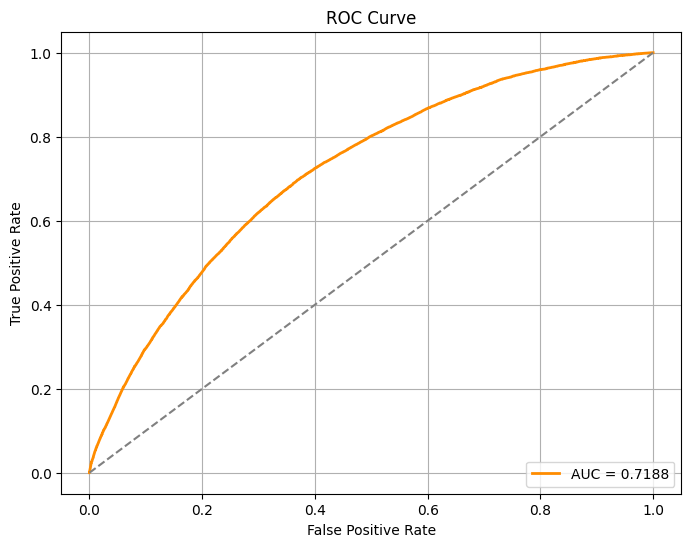

In [40]:
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

- X-axis = False Positive Rate (FPR) → Type I error.
- Y-axis = True Positive Rate (TPR) → Recall.

The closer the curve is to the top-left corner, the better the model.

## KS Statistic (Kolmogorov–Smirnov)

- KS Statistic = max separation between TPR and FPR.
- Common metric in banking to measure how well the model separates classes.

In [41]:
ks = max(tpr - fpr)
print(f"KS Statistic: {ks:.4f}")

KS Statistic: 0.3280


Solid score, acceptable for a credit scorecard in production.

# Scale To Credit Scores

In [42]:
# Define X again using final WOE features
X = df[final_woe_features]

In [43]:
# Define Parameters for Score Scaling
PDO = 20           # Points to Double the Odds
BaseScore = 600    # Score assigned to base odds
BaseOdds = 50      # Base odds = Good : Bad = 50:1

In [44]:
# Convert Logistic Output to Score
# Score = Offset – Factor × log-odds
Factor = PDO / np.log(2)
Offset = BaseScore - Factor * np.log(BaseOdds)

log_odds = model.intercept_ + np.dot(X, model.coef_.T).reshape(-1)
df['score'] = Offset - Factor * log_odds

In [45]:
df[['score', 'target']].head()

,score,target
0,542.873200,0
1,526.309208,1
2,512.629943,0
3,544.345868,0
4,545.853245,0


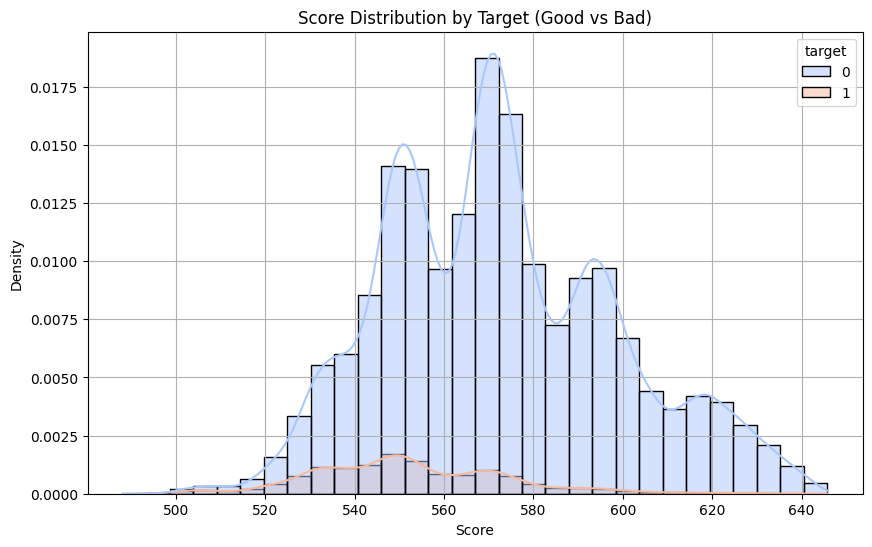

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='score', hue='target', bins=30, kde=True, palette='coolwarm', stat='density')
plt.title('Score Distribution by Target (Good vs Bad)')
plt.xlabel('Score')
plt.ylabel('Density')
plt.grid(True)
plt.show()

- Good (0) borrowers skew right (higher scores)
- Bad (1) borrowers skew left (lower scores)

The separation shows the discriminative power of the scorecard

# Scorecard Table

Scorecard: a mapping between each bin of a variable and its corresponding score contribution.

**Formula for Score per Bin**:
$$
points = -coef * woe * Factor
$$
Where:
- coef = model coefficient for that feature
- woe = Weight of Evidence for that bin
- Factor = scaling factor from PDO

In [47]:
Factor = 20 / np.log(2)  # scaling factor ≈ 28.85

scorecard_rows = []

for feature, coef in zip(final_woe_features, model.coef_[0]):
    base_feature = feature.replace('_woe', '')
    
    # If it's a binned feature, use the bin column
    if base_feature + '_bin' in df.columns:
        group_col = base_feature + '_bin'
    else:
        group_col = base_feature  # categorical feature

    try:
        grouped = df.groupby(group_col)['target'].agg(['count', 'sum'])
        grouped.columns = ['total', 'bad']
        grouped['good'] = grouped['total'] - grouped['bad']

        dist_good = grouped['good'] / grouped['good'].sum()
        dist_bad = grouped['bad'] / grouped['bad'].sum()
        grouped['woe'] = np.log((dist_good + 1e-6) / (dist_bad + 1e-6))

        for bin_label, row in grouped.iterrows():
            woe = row['woe']
            points = -coef * woe * Factor
            scorecard_rows.append({
                'feature': base_feature,
                'bin': str(bin_label),
                'woe': round(woe, 4),
                'coefficient': round(coef, 4),
                'points': round(points, 2)
            })
    
    except Exception as e:
        print(f"❌ Error processing {base_feature}: {e}")

# Final scorecard as DataFrame
scorecard_df = pd.DataFrame(scorecard_rows).sort_values(by=['feature', 'bin'])


In [48]:
print(scorecard_df)

                  feature                    bin     woe  coefficient  points
15             annual_inc        (-inf, 43202.0] -0.2922      -0.3650   -3.08
19             annual_inc        (100129.0, inf]  0.3962      -0.3650    4.17
16             annual_inc     (43202.0, 66100.5] -0.0839      -0.3650   -0.88
17             annual_inc   (66100.5, 80046.219]  0.0909      -0.3650    0.96
18             annual_inc  (80046.219, 100129.0]  0.2157      -0.3650    2.27
39  credit_history_length          (-inf, 7.336] -0.4267      -0.3059   -3.77
41  credit_history_length       (13.593, 19.092]  0.0574      -0.3059    0.51
42  credit_history_length       (19.092, 24.768]  0.2339      -0.3059    2.06
43  credit_history_length          (24.768, inf]  0.3328      -0.3059    2.94
40  credit_history_length        (7.336, 13.593] -0.1416      -0.3059   -1.25
0                int_rate          (-inf, 7.275]  1.8652      -0.9463   50.93
3                int_rate         (14.03, 18.58] -0.3812      -0

The final scorecard translates model coefficients and WOE values into interpretable point contributions for each feature bin. This makes the logistic regression model transparent, auditable, and suitable for real-world credit decisioning.

**How to Read the Scorecard:**

Each row corresponds to a specific bin (range or category) of a feature:
- WOE: Weight of Evidence for that bin, representing the strength and direction of its association with default risk.
- Coefficient: The logistic regression weight for the feature.
- Points: Contribution to the borrower’s final credit score.
    + Positive points → Lower risk (more “good” borrowers)
    + Negative points → Higher risk (more “bad” borrowers)